# Lane Detection Use Edge Detection and RANSAC

Import all necessary libraries.

In [1]:
from time import time
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

### Part 1 - Image Pre-processing

Display the original example image.

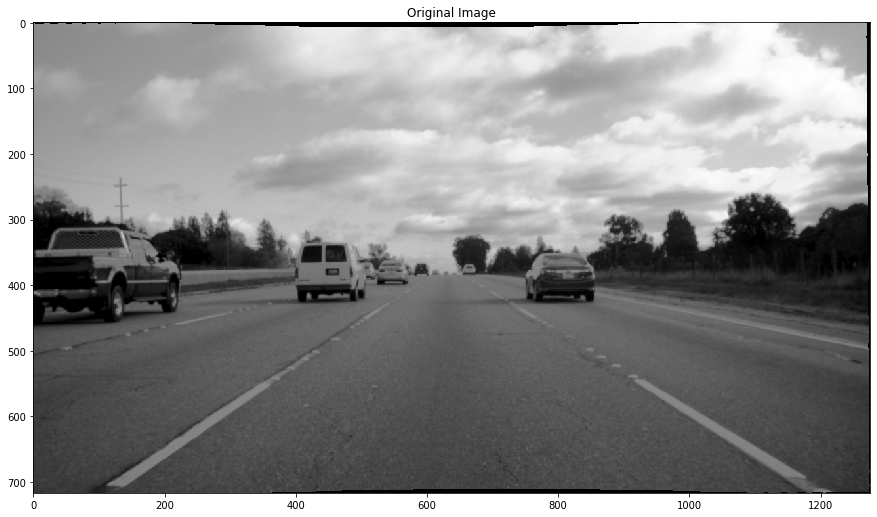

In [2]:
img = io.imread('example_image1.png', as_gray=True) # shape = (717,1276)
plt.imshow(img)
plt.title('Original Image')
plt.show()

 Notice that the above image has some noisy borders which is likely to affect lane detection. Let's prune them out.

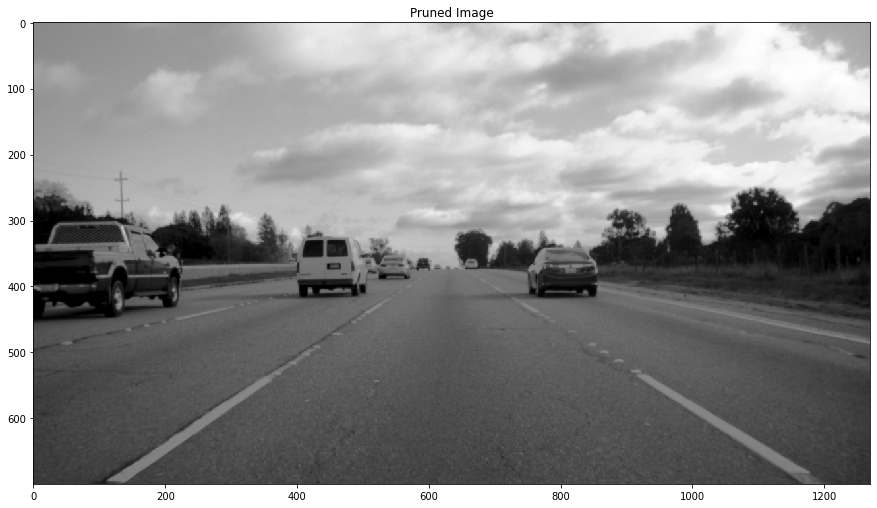

In [3]:
img_pruned = img[10:710,:1270] # shape = (700,1270)
plt.imshow(img_pruned)
plt.title('Pruned Image')
plt.show()

### Part 2 - Detect Edges Using Canny Edge Detector

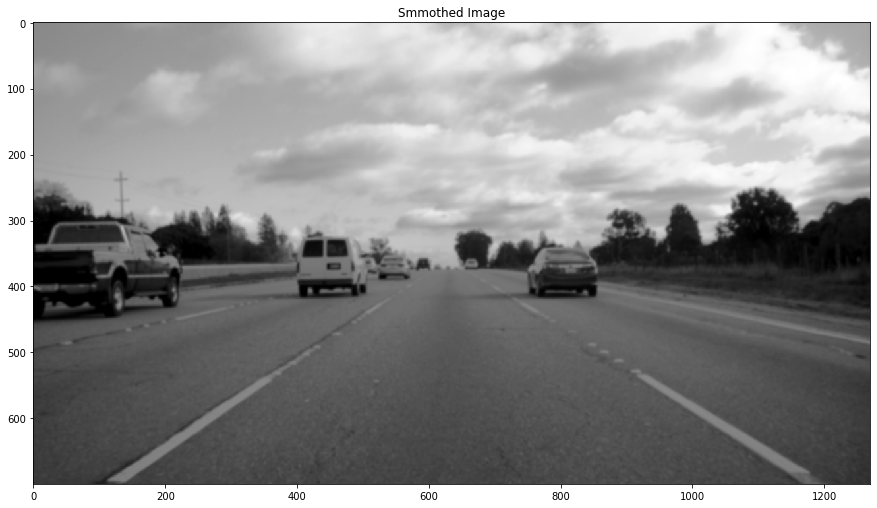

In [4]:
from functions import smoothing
kernel_size = 5
sigma = 1.4
smoothed_img = smoothing(img_pruned, kernel_size, sigma)
plt.imshow(smoothed_img)
plt.title('Smmothed Image')
plt.show()

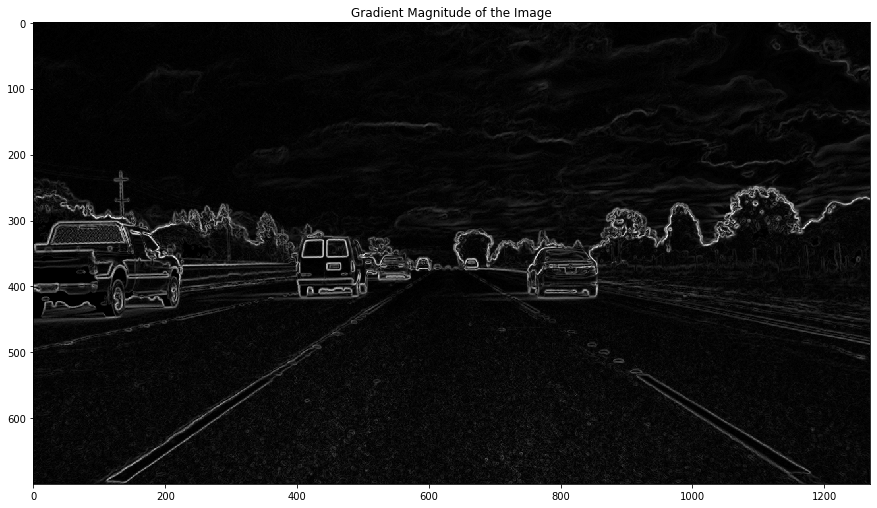

In [5]:
from functions import gradient
kernel_size = 5
sigma = 1.4
gradient, theta = gradient(img_pruned, kernel_size, sigma)
plt.imshow(gradient)
plt.title('Gradient Magnitude of the Image')
plt.show()

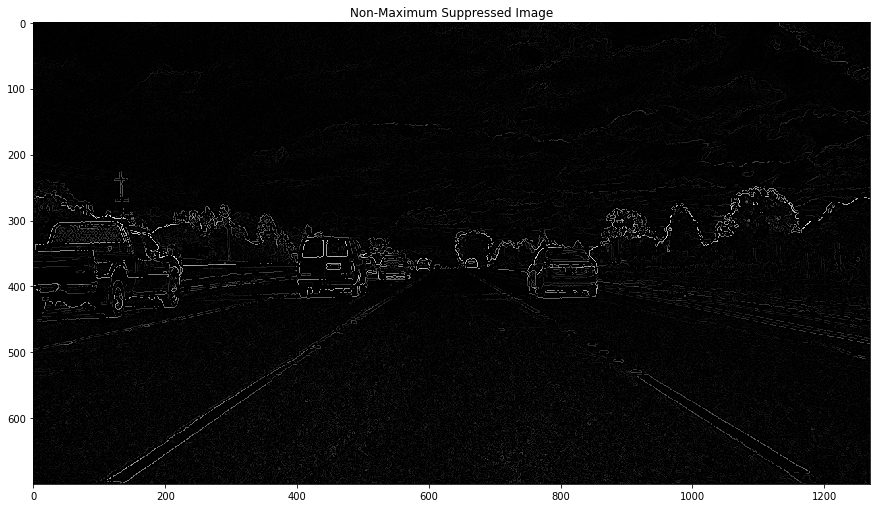

In [6]:
from functions import NMS
kernel_size = 5
sigma = 1.4
NMS_img = NMS(img_pruned, kernel_size, sigma)
plt.imshow(NMS_img)
plt.title('Non-Maximum Suppressed Image')
plt.show()

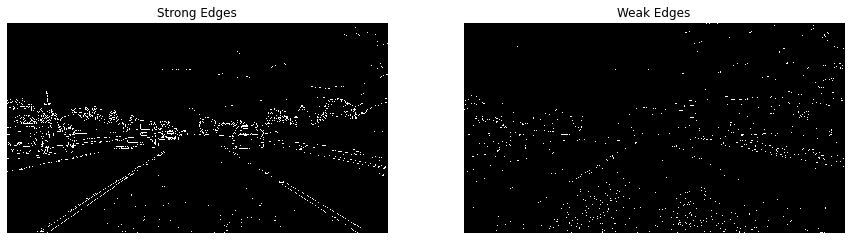

In [7]:
from functions import double_threshold
low_thres = 6
high_thres = 8
kernel_size = 5
sigma = 1.4
strong_edges, weak_edges = double_threshold(img_pruned, kernel_size, sigma, high_thres, low_thres)

# Plot Strong and Weak Edges
plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(weak_edges)
plt.title('Weak Edges')
plt.axis('off')
plt.show()

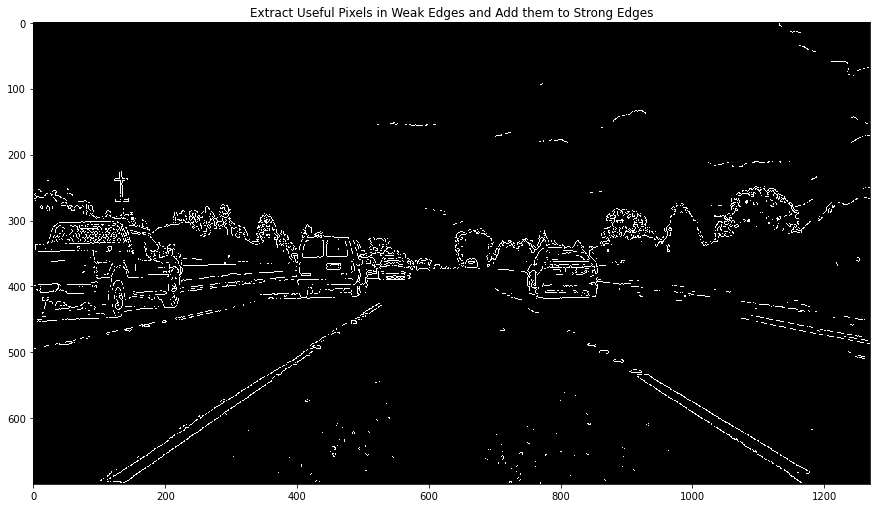

In [8]:
from functions import link_edges
low_thres = 8
high_thres = 10
kernel_size = 5
sigma = 1.4
edges = link_edges(img_pruned, kernel_size, sigma, high_thres, low_thres)

plt.imshow(edges)
plt.title('Extract Useful Pixels in Weak Edges and Add them to Strong Edges')
plt.show()

### Part 3 - Extract Region of Interest

Some regions of the edge map is considered as 'useless'. For example, the lanes will definitely not appear in the upper half of the image. We could filter out these irrelevant edge information by applying ROI extracction, as shown below.

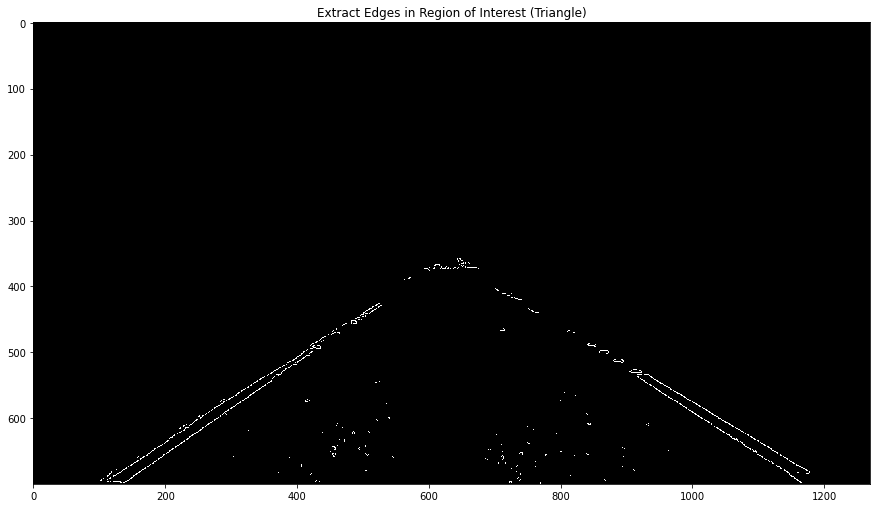

In [9]:
from functions import ROI_Triangle
roi_img = ROI_Triangle(edges)
plt.imshow(roi_img)
plt.title('Extract Edges in Region of Interest (Triangle)')
plt.show()

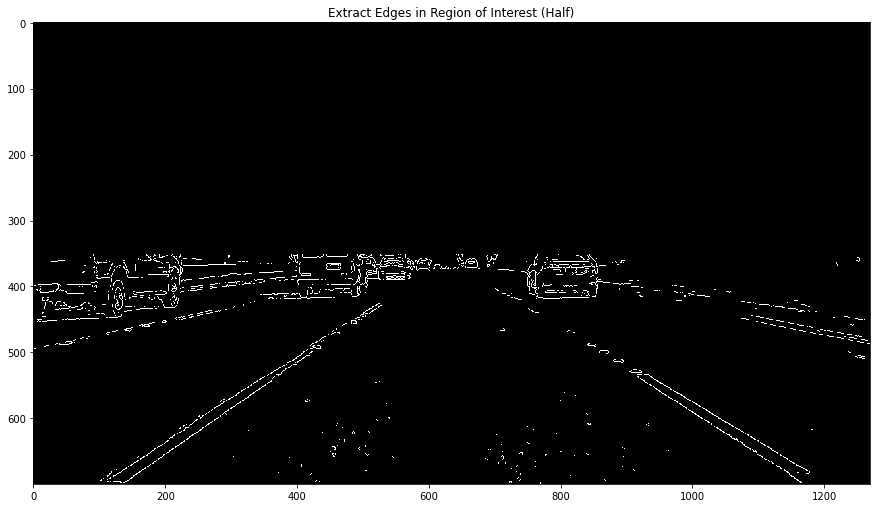

In [10]:
from functions import ROI_Half
roi_img1 = ROI_Half(edges)
plt.imshow(roi_img1)
plt.title('Extract Edges in Region of Interest (Half)')
plt.show()

### Part 4 - Apply Hough Transform

Now, apply Hough Transform on the ROI image to detect lanes.

In [11]:
from functions import hough

# Perform Hough Transform on the ROI
hough_space, rhos, thetas = hough(roi_img)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

# Find the peak points in Hough Space
for i in range(20):
    # Find peak point
    idx = np.argmax(hough_space)
    r_idx = idx // hough_space.shape[1] # Calculate rho-coordinate
    t_idx = idx % hough_space.shape[1] # Calculate theta-coordinate
    hough_space[r_idx, t_idx] = 0 # Zero out the max value in hough space
    
    # Transform a point in Hough space to a line in xy-space.
    rho = rhos[r_idx]
    theta = thetas[t_idx]
    a = - (np.cos(theta) / np.sin(theta)) # slope of the line
    b = (rho / np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break
    
    if a < 0: # Left lane detected
        if xs_left:
            continue
        for x in range(img.shape[1]):
            y = a * x + b
            if y > img.shape[0] * 0.55 and y < img.shape[0]:
                xs_left.append(x)
                ys_left.append(int(round(y)))
    else: # Right Lane detected
        if xs_right:
            continue
        for x in range(img.shape[1]):
            y = a * x + b
            if y > img.shape[0] * 0.55 and y < img.shape[0]:
                xs_right.append(x)
                ys_right.append(int(round(y)))

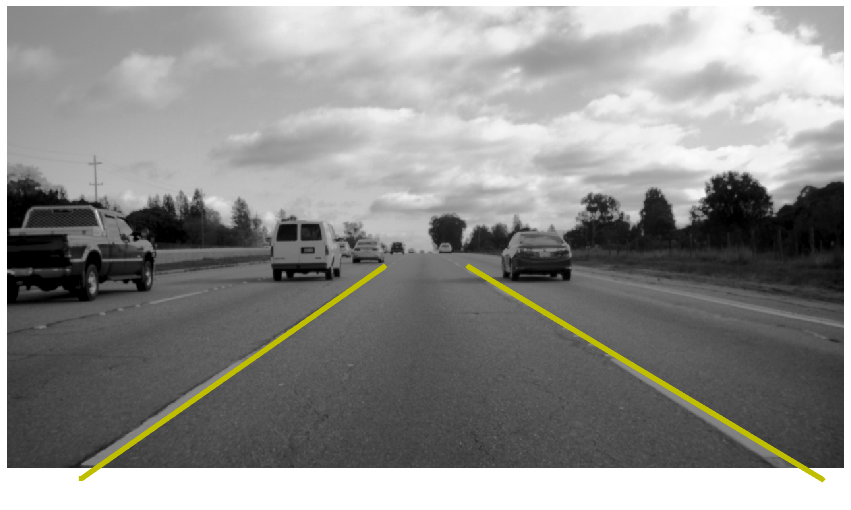

In [12]:
plt.imshow(img_pruned)
plt.plot(xs_left, ys_left, linewidth=5.0, color ='y')
plt.plot(xs_right, ys_right, linewidth=5.0, color ='y')
plt.axis('off')
plt.show()